In [5]:
#Reference : https://www.tensorflow.org/tutorials/text/nmt_with_attention
#Please upload Nirmala.ttf file to view the heatmap correctly

In [6]:
#importing the required libraries
import tensorflow as tf

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import numpy as np
from random import randrange 
from google.colab import files
import pandas as pd


In [7]:
#To plot heatmap with Indic languages as ticks
from matplotlib.font_manager import FontProperties
tamil_font = FontProperties(fname = 'Nirmala.ttf')

In [8]:
#get the data set 
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xf 'dakshina_dataset_v1.0.tar'

--2021-05-23 12:23:13--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  75.8MB/s    in 27s     

2021-05-23 12:23:40 (70.6 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [9]:
#setting the path to tamil dataset
train_tamil_path = "/content/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv"
val_tamil_path="/content/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv"
test_tamil_path="/content/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"



In [10]:
#function to create dataset from the path
def create_dataset(path):
  input_texts = []
  target_texts = []
  with open(path, "r", encoding="utf-8") as f:
    data_lines = f.read().split("\n")
  data_lines.pop()

#go through the data(can be train,val or test) lines and split them into 3 and save input and target 
  for line in data_lines[: (len(data_lines) - 1)]:
    #because we want english to devanagiri conversion 
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_text = "\t" +input_text + "\n"
    #append it to the main input texts list
    input_texts.append(input_text)
    #append it to the main target texts list 
    target_texts.append(target_text)
  
  return (input_texts,target_texts)



In [11]:
#function to tokenize the data 
def tokenize(lang):
  #setting char_level parameter as true because by default it is word tokenizer, but 
  #we want character tokenizer
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')

  return tensor, lang_tokenizer

In [12]:
#function that uses create_dataset function and tokenize function together to finally get
#the processed data 
def load_dataset(path):
  # creating cleaned input, output pairs
  inp_lang,targ_lang = create_dataset(path)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [13]:
#function to check the token mapping
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      #print(t)
      print(f'{t} ----> {lang.index_word[t]}')


In [14]:
#encoder class
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz,cell_type,drop):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.cell_type=cell_type
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.dropout=drop
    if(cell_type=='lstm'):
      self.cell = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='gru'):
      self.cell = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='rnn'):
      self.cell = tf.keras.layers.SimpleRNN(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)

  def call(self, x): 
    x = self.embedding(x)
    if(self.cell_type=='lstm'):
      output, state_h,state_c = self.cell(x)
      return output, state_h,[state_h,state_c]
    elif(self.cell_type=='gru'):
      output, state = self.cell(x)
      return output, state,state
    elif(self.cell_type=='rnn'):
      output, state = self.cell(x)
      return output, state,state


In [15]:
#Class for attention layer using Bahdanau Style 
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [16]:
#Class for Decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,cell_type,drop):
    super(Decoder, self).__init__()
    self.cell_type=cell_type
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.dropout=drop
    if(cell_type=='lstm'):
      self.cell = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='gru'):
      self.cell = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)
    elif(cell_type=='rnn'):
      self.cell = tf.keras.layers.SimpleRNN(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',dropout=self.dropout)


    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output,states):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    if(self.cell_type=='lstm'):
    # passing the concatenated vector to the GRU
      output, state,state_c = self.cell(x,initial_state=states)

    # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state,[state,state_c], attention_weights
    elif(self.cell_type=='gru'):
      output, state = self.cell(x,initial_state=states)

    # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, state, attention_weights
    elif(self.cell_type=='rnn'):
      output, state = self.cell(x,initial_state=states)

    # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, state, attention_weights

In [17]:
#define optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [18]:
#Train function 
@tf.function
def train_step(inp, targ):
    loss = 0
    #print(type(encoder))
    with tf.GradientTape() as tape:
      enc_output, enc_hidden,states = encoder(inp)
      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['\t']] * batchSize, 1)

    # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
        predictions, dec_hidden, states,_ = decoder(dec_input, dec_hidden, enc_output,states)
      #states=[dec_hidden,enc_c]
        loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [19]:
#inference function
def evaluate(word):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #we are not adding \t and \n to the word here since the validation and test data
    #already comes with the start and stop words \t and \n
    #word = '\t'+word+'\n'

    inputs = [inp_lang.word_index[i] for i in list(word)]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    enc_out, enc_hidden,states = encoder(inputs)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['\t']], 0)

    for t in range(max_length_targ):
      predictions, dec_hidden, states,attention_weights = decoder(dec_input,dec_hidden,enc_out,states)
    
    # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      predicted_id = tf.argmax(predictions[0]).numpy()

      result += targ_lang.index_word[predicted_id] 

      if targ_lang.index_word[predicted_id] == '\n':
        return result, word, attention_plot

    # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

    return result,word,attention_plot

In [20]:
#Create the training tensor, validation tensor
#calculate vocabulary size,maxlength
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(train_tamil_path)
input_tensor_val,target_tensor_val,_,_=load_dataset(val_tamil_path)

word_val_input,word_val_target=create_dataset(val_tamil_path)
word_test_input,word_test_target=create_dataset(test_tamil_path)
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
BUFFER_SIZE = len(input_tensor)
# Calculate max_length of the target and input tensor
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
#check size of training and validation data both input and target 
print(len(input_tensor), len(target_tensor), len(input_tensor_val), len(target_tensor_val))



68217 68217 6826 6826


In [24]:
#check a random word
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor[3])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor[3])


Input Language; index to word mapping
2 ----> 	
27 ----> f
4 ----> i
9 ----> r
1 ----> a
1 ----> a
8 ----> n
20 ----> s
3 ----> 


Target Language; index to word mapping
2 ----> 	
48 ----> ஃ
8 ----> ப
5 ----> ி
10 ----> ர
9 ----> ா
13 ----> ன
1 ----> ்
33 ----> ஸ
1 ----> ்
3 ----> 



In [25]:
#best model from sweep
embedding_dim=256
units=512
batchSize=64
EPOCHS=15
cell_type='lstm'
drop=0.2
steps_per_epoch=len(input_tensor)//batchSize
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(batchSize, drop_remainder=True)


In [26]:
#define the encoder and decoder object
encoder = Encoder(vocab_inp_size, embedding_dim, units, batchSize,cell_type,drop)
decoder = Decoder(vocab_tar_size, embedding_dim, units, batchSize,cell_type,drop)


In [27]:
#Training
for epoch in range(EPOCHS):
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')


  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')


Epoch 1 Batch 0 Loss 1.4206
Epoch 1 Batch 100 Loss 0.7422
Epoch 1 Batch 200 Loss 0.6681
Epoch 1 Batch 300 Loss 0.4085
Epoch 1 Batch 400 Loss 0.2732
Epoch 1 Batch 500 Loss 0.1882
Epoch 1 Batch 600 Loss 0.1061
Epoch 1 Batch 700 Loss 0.1550
Epoch 1 Batch 800 Loss 0.1156
Epoch 1 Batch 900 Loss 0.0940
Epoch 1 Batch 1000 Loss 0.1028
Epoch 1 Loss 0.3163
Epoch 2 Batch 0 Loss 0.0802
Epoch 2 Batch 100 Loss 0.0663
Epoch 2 Batch 200 Loss 0.1045
Epoch 2 Batch 300 Loss 0.0666
Epoch 2 Batch 400 Loss 0.0815
Epoch 2 Batch 500 Loss 0.0866
Epoch 2 Batch 600 Loss 0.0538
Epoch 2 Batch 700 Loss 0.0801
Epoch 2 Batch 800 Loss 0.0455
Epoch 2 Batch 900 Loss 0.0551
Epoch 2 Batch 1000 Loss 0.0678
Epoch 2 Loss 0.0791
Epoch 3 Batch 0 Loss 0.0788
Epoch 3 Batch 100 Loss 0.0451
Epoch 3 Batch 200 Loss 0.0428
Epoch 3 Batch 300 Loss 0.0961
Epoch 3 Batch 400 Loss 0.0400
Epoch 3 Batch 500 Loss 0.0563
Epoch 3 Batch 600 Loss 0.0525
Epoch 3 Batch 700 Loss 0.0629
Epoch 3 Batch 800 Loss 0.0743
Epoch 3 Batch 900 Loss 0.0400
Epoc

In [28]:
def translate(word):
  result, word, attention_plot = evaluate(word)
  return result


In [29]:
#can change the word and check for other predictions 
#replace vanakkam with word of your choice within \t and \n
translate('\tvanakkam\n')

'வணக்கம்\n'

In [31]:
#Calculate the validation accuracy  
count=0
for i in range(len(word_val_input)):
  pred,_,_=evaluate(word_val_input[i])
  pred=pred.strip('\n')
  actual=word_val_target[i]
  actual=actual.strip('\n''\t')
  if(pred==actual):
    count+=1
  
val_acc=count/len(word_val_input)
print("Validation accuracy",val_acc)

Validation accuracy 0.5536185174333431


In [33]:
#test accuracy , also store it in a csv file
count=0
df = pd.DataFrame(columns=['SourceText', 'Prediction', 'GroundTruth'])

for i in range(len(word_test_input)):
  pred,_,_=evaluate(word_test_input[i])
  pred=pred.strip('\n')
  actual=word_test_target[i]
  actual=actual.strip()
  if(pred==actual):
    count+=1
  row = {}
  row['SourceText'] = word_test_input[i].strip()
  row['GroundTruth'] = actual
  row['Prediction'] = pred
  df = df.append(row, ignore_index=True)

df.to_csv('predictions_attention.csv', index=False)  
files.download('predictions_attention.csv')
test_acc=count/len(word_test_input)
print("Test accuracy",test_acc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test accuracy 0.5392685414541746


In [34]:
#function to  plot the grid
def plot_attention_grid():
  fig=plt.figure(figsize=(20,20))
  #fig.tight_layout()
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=0.6,wspace=0.1) 
  fontdict={'fontsize':15}
  for i in range(1,11):
    result,word,attention_plot = evaluate(word_val_input[randrange(len(word_val_input))])
    attention_plot = attention_plot[:len(list(result)),:len(list(word))]
    word=['<s>'] + list(word.strip()) + ['<e>']
    result= list(result.strip()) + ['<e>']
    ax = fig.add_subplot(4, 3, i)
    ax.matshow(attention_plot,cmap='viridis')
    ax.set_xticklabels([''] + word, fontdict=fontdict, rotation=45)
    ax.set_yticklabels([''] + result, fontdict=fontdict,fontproperties=tamil_font)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1)) 
  
  plt.show()

  

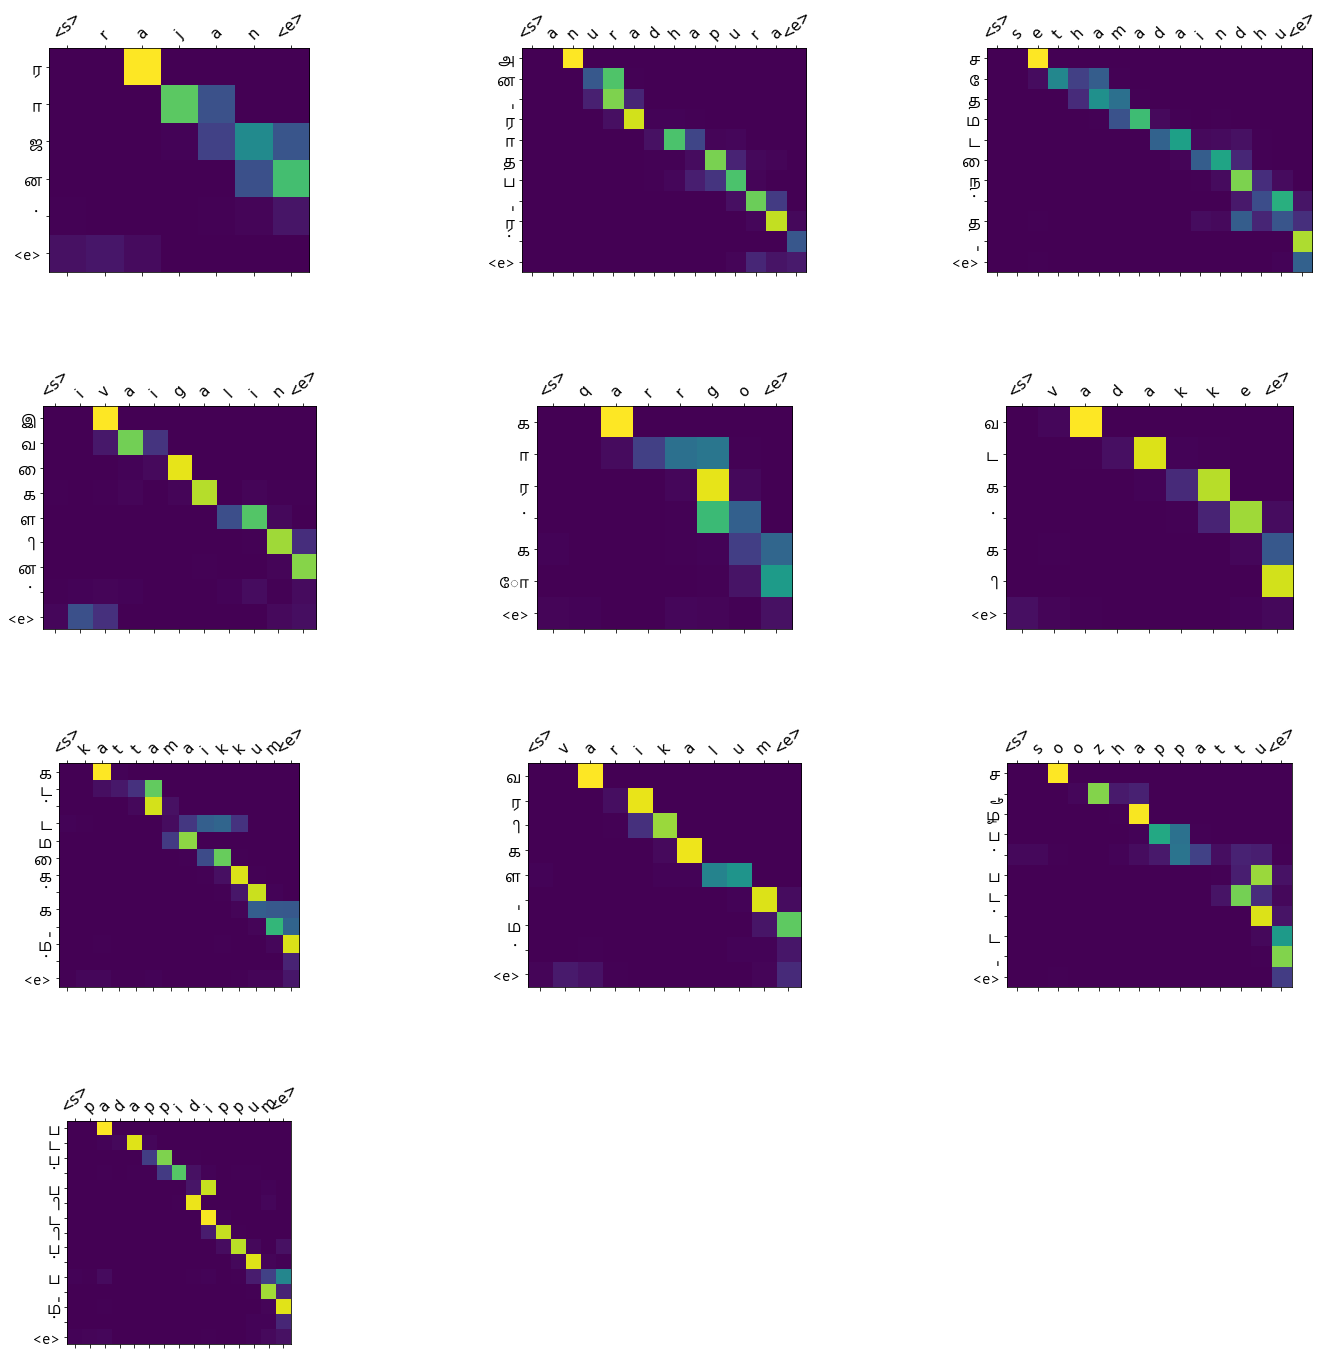

In [35]:
plot_attention_grid()

In [38]:
def visualize(word):
  pred, word, arr = evaluate(word)
  arr = arr[:len(list(pred)),:len(list(word))]
  with open("head.txt") as h:
    with open("tail.txt") as t:
      with open("output.html","w") as f:
        for line in h:
              f.write(line)
        f.write('weight[0]=')
        f.write(str(arr.tolist()))
        f.write('\n')
        f.write('sourceText[0]=')
        f.write(repr(word))
        f.write('\n')
        f.write('targetText[0]=')
        f.write(str(list(pred)))
        f.write('\n')
        for line in t:
          f.write(line)

  f.close()
  h.close()
  t.close()


In [39]:
#change to see other words visualization
#upload head.txt,tail.txt
#this will generate output.html which can be downloaded to see the visualization
visualize('\tchappathi\n')

For wandb sweeps please run the below blocks

In [40]:
%pip install wandb -q
import wandb

     |████████████████████████████████| 1.8MB 3.0MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 133kB 18.4MB/s 
     |████████████████████████████████| 174kB 19.8MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 


In [41]:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'   
    },
    'early_terminate':{
  'type': 'hyperband',
  'min_iter': 5
    },
    'parameters': {
        'epochs':{
          'values':[10,15]  
        },
        #embedding
        'embedding': {
            'values': [32,64,256]
        },
        'hidden': {
            'values': [128,256,512,1024]
        },
        #100% means no fine tuning, only pre training
        'cell':{
            'values': ['rnn','gru','lstm']
        
        },
        'dropout': {
            'values':[0,0.2,0.3]
        },
        'batch_size':{
            'values':[32,64]
        }

    }
}

In [42]:
!wandb login 781ea05d3016dc46e417672b13ee6d7047c00562 

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [43]:
sweep_id = wandb.sweep(sweep_config,entity='akceg', project="cs6910-assignment3-attention_testing") 

Create sweep with ID: 0epaeust
Sweep URL: https://wandb.ai/akceg/cs6910-assignment3-attention_testing/sweeps/0epaeust


In [44]:
def evaluate(word,encoder,decoder):
  #word = '\t'+word+'\n'

    inputs = [inp_lang.word_index[i] for i in list(word)]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    enc_out, enc_hidden,states = encoder(inputs)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['\t']], 0)

    for t in range(max_length_targ):

      predictions, dec_hidden, states,_ = decoder(dec_input,dec_hidden,enc_out,states)

      predicted_id = tf.argmax(predictions[0]).numpy()

      result += targ_lang.index_word[predicted_id] 

      if targ_lang.index_word[predicted_id] == '\n':
        return result, word

    # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

    return result, word

In [45]:
def train():
  
  wandb.init()
  config = wandb.config
  n=str(config.cell)+"_hidden"+str(config.hidden)+"_embed"+str(config.embedding)+"_drop"+str(config.dropout)+"_epoch"+str(config.epochs)+"_batch"+str(config.batch_size)
  wandb.run.name=n
  BATCH_SIZE = config.batch_size
  steps_per_epoch = len(input_tensor)//BATCH_SIZE
  embedding_dim = config.embedding
  units = config.hidden
  drop=config.dropout
  EPOCHS=config.epochs
  cell=config.cell
  dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE,cell,drop)
  decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE,cell,drop)
  @tf.function
  def train_step(inp, targ):
    loss = 0

    with tf.GradientTape() as tape:
      enc_output, enc_hidden,states = encoder(inp)
      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['\t']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
        predictions, dec_hidden, states,_ = decoder(dec_input, dec_hidden, enc_output,states)

        loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
  
  for epoch in range(EPOCHS):

    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ)
      total_loss += batch_loss

      if batch % 100 == 0:
        print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')


    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    wandb.log({'train_loss': total_loss/steps_per_epoch,'epochs':epoch+1 })

  #validation accuracy
  
  count=0
  for i in range(len(word_val_input)):
    pred,_=evaluate(word_val_input[i],encoder,decoder)
    pred=pred.strip('\n')
    actual=word_val_target[i]
    actual=actual.strip('\n''\t')
    if(pred==actual):
      count+=1
  
  val_acc=count/len(word_val_input)
  print("Validation accuracy",val_acc)
  wandb.log({'val_acc': val_acc})



In [46]:
wandb.agent(sweep_id, train,count=9,project="cs6910-assignment3-attention_testing")

wandb: Agent Starting Run: 4211zh3x with config:
wandb: 	batch_size: 64
wandb: 	cell: gru
wandb: 	dropout: 0.3
wandb: 	embedding: 32
wandb: 	epochs: 10
wandb: 	hidden: 1024
wandb: Currently logged in as: akceg (use `wandb login --relogin` to force relogin)


wandb: Ctrl + C detected. Stopping sweep.
